In [36]:
# Import dependencies

import os
import glob
import matplotlib.pyplot as plt
import numpy as np

import rasterio
from rasterio.plot import show
import imageio

from tqdm import tqdm

import rioxarray

In [48]:
# We will first need to choose the country. The available countries are:
avail_countries = [os.path.split(subfolder)[1] for subfolder in glob.glob("Data/PopDensity/*")]
print(f"The available countries are: {avail_countries}")

The available countries are: ['Germany', 'Czechia']


In [38]:
# Choose a country
country = 'Germany'

In [49]:
# We will also need to choose a year. The available years for the chosen country are:
avail_years = [os.path.split(subfolder)[1] for subfolder in glob.glob(f'Data/PopDensity/{country}/*')]
print(f"The available years for {country} are: {avail_years}")

The available years for Germany are: ['2020']


In [40]:
# Choose a year
year = 2020

In [50]:
# Now find the associated tif
file = glob.glob(f'Data/PopDensity/{country}/{year}/*.tif')[0]


# Open the tif and extract the relevant information
with rasterio.open(file) as src:
    band = src.read(1)
    meta = src.meta
    transform = src.transform
    crs = src.crs
    mask = np.array(src.read_masks(1)/255, dtype=bool)
    
# Create a copy of the band with the masked values represented with 0 instead of -99999.0
band0 = np.where(band <0, 0, band)

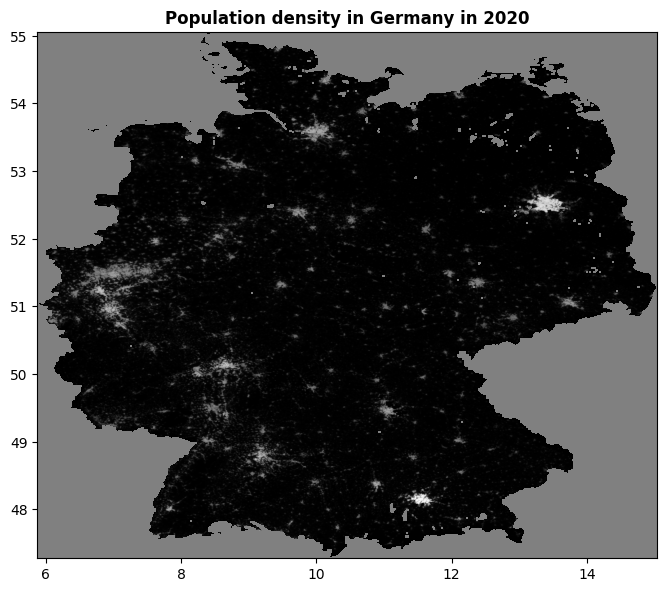

In [53]:
# We can apply the mask to our data to obtain only the parts for which we have data (we need to invert the mask because we are 'masking away' the bad stuff
masked_band = np.ma.masked_array(band, ~mask)

# Let's visualise this data now

cmap = plt.cm.get_cmap("Greys_r").copy()
cmap.set_bad(color='grey')


fig, ax = plt.subplots(figsize=(8,8))
show(masked_band, transform=transform, title=f'Population density in {country} in {year}', cmap=cmap)
plt.show()

In [ ]:
# To write a function which generates the data we first need two functions
# The first function calculates the RHS of the differential equation
def f(u):
    S = u[0]
    I = u[1]
    R = u[2]
    
    
    new = np.array([-beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]),
                     beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]) - gamma*I[1:-1, 1:-1],
                     gamma*I[1:-1, 1:-1]
                    ])
    
    # Here we want to apply the mask
    padding = np.zeros_like(u)
    padding[:,1:-1,1:-1] = new
    
    # First apply the mask to each layer
    padding[0] = np.ma.masked_array(padding[0], ~mask)
    padding[1] = np.ma.masked_array(padding[1], ~mask)
    padding[2] = np.ma.masked_array(padding[2], ~mask)
    

    
    return padding

# The second function implements the step forward algorithm which numerically solves the PDE
# It also clips the population to stop it from going above the maximum or below zero
def euler_step(u, f, dt):
    newu = u + dt * f(u)
    
    # Set anything below 0 to 0
    newu[0] = np.where(newu[0]<0, 0, newu[0])
    newu[1] = np.where(newu[1]<0, 0, newu[1])
    newu[2] = np.where(newu[2]<0, 0, newu[2])    
    
    # Now set anything above max to max
    newu[0] = np.where(newu[0]>band0, np.maximum(newu[0], band0), newu[0])
    newu[1] = np.where(newu[1]>band0, np.maximum(newu[1], band0), newu[1])
    newu[2] = np.where(newu[2]>band0, np.maximum(newu[2], band0), newu[2])
    
    
    
    
    return newu


In [56]:
def generate_data(T=99, dt=1, alpha = 0.001, beta = 0.01):
    '''
    Numerically solves the SIR equation. 
    inputs:
        T - total time the simulation runs
        dt - the length of a single time step
        alpha - the alpha parameter in the SIR equation
        beta - the beta parameter in the SIR equation
        
    output:
        u - the solution to the SIR equation with given parameters and initial conditions
    
    '''
    
    # Calculate the number of timesteps required based on the total time T and timestep dt
    N = int(T/dt) + 1               # number of time-steps
    t = np.linspace(0.0, T, N)      # time discretization

    # The initial conditions

    # u will be a 4-dimensional array consisting of the S,I, and R values at each gridpoint and each time
    u = np.zeros((N, 3, band.shape[0], band.shape[1]))
    
    # The initial susceptible population is just the population density
    u[0, 0, :,:] = masked_band

    # We need to set the masked data to zero (masked data was originally -9999)
    u[0,0][u[0,0]<0] = 0

    # The initial infected population is mostly zero
    # However we will inject a "patient zero" at the most densely populated part of the country
    u[0, 1, max_idx[0], max_idx[1]] = 1

    # The removed part of the population is initially zero
    
    
    # Run the code
    for n in tqdm(range(N-1)):
        u[n+1] = euler_step(u[n], f, dt)
        
    
    
    return u

In [ ]:
def generate_imgs(data, frames):
    '''
    Generates images associated with the solution given by u.
    inputs: 
        data - solution obtained from the generate_data function 
        
    output:
        
    '''